In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator
from qiskit import transpile

import pylatexenc

# for testing
# from random import random, randint, choice

import numpy as np
# make numpy output look better
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")

import matplotlib.pyplot as plt
# %matplotlib inline

# style
# plt.rcParams['figure.figsize'] = (10, 8)
# plt.style.use('fivethirtyeight')
plt.style.use("ggplot")

# Five Qubit Error-Correcting Code

## Stabilizer Group

We follow Nielsen and Chuang's [Quantum Computation and Quantum Information](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview), Section 10.5.6.

Generators of the stabilizer group:

$$
  \begin{align*}
    g_0 &= X \otimes Z \otimes Z \otimes X \otimes \mathbb{I}. \\
    g_1 &= \mathbb{I} \otimes X \otimes Z \otimes Z \otimes X ,\\
    g_2 &= X \otimes \mathbb{I} \otimes X \otimes Z \otimes Z ,\\
    g_3 &= Z \otimes X \otimes \mathbb{I} \otimes X \otimes Z, \\
  \end{align*}
$$

In [2]:
g_gates_str = [
    ["x", "z", "z", "x", "i"],
    ["i", "x", "z", "z", "x"],
    ["x", "i", "x", "z", "z"],
    ["z", "x", "i", "x", "z"],
]

In [3]:
g = []

for gates in g_gates_str:
    quantum_register = QuantumRegister(size=len(gates), name="x")
    circuit = QuantumCircuit(quantum_register)
    for j, gate in enumerate(gates):
        if gate == "x":
            circuit.x(j)
        elif gate == "z":
            circuit.z(j)
    g.append(circuit)

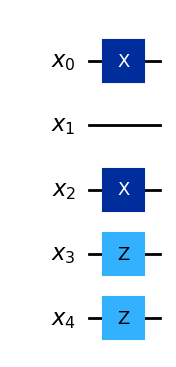

In [4]:
i = 2
g[i].draw("mpl")

## Encoding

We follow a clever construction from [Stack Exchange](https://quantumcomputing.stackexchange.com/)'s thread [Nielsen&Chuang 5-qubit quantum error-correction encoding gate](https://quantumcomputing.stackexchange.com/questions/14264/nielsenchuang-5-qubit-quantum-error-correction-encoding-gate).

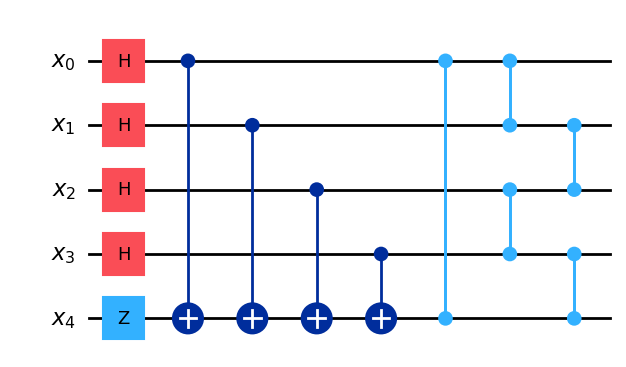

In [5]:
quantum_register = QuantumRegister(size=5, name="x")
encoder_circ = QuantumCircuit(quantum_register)

encoder_circ.h(quantum_register[:-1])
encoder_circ.z(-1)
for i in range(4):
    encoder_circ.cx(i, 4)
encoder_circ.cz(0, 4)
for i in range(0, 4, 2):
    encoder_circ.cz(i, i + 1)
for i in range(1, 5, 2):
    encoder_circ.cz(i, i + 1)

encoder_circ.draw("mpl")

In [6]:
logical_0 = Statevector(encoder_circ)

Let's check that the coefficients are what we expect.  They should all be real:

In [7]:
for x in logical_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should all be $0$ or $\pm 1/4$:

In [8]:
a = np.abs(4 * logical_0.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

In [9]:
def binary_digits(a, n):
    """
    Given a and n, returns the first n digits of the binary representation of a.

    INPUTS:
    * a: A positive integer;
    * n: the number of binary digits.

    OUTPUT:
    An array of length n containing the first n binary digits of a, from letft to right.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


for i, coef in enumerate(4 * logical_0.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

  1: [0 0 0 0 0]
 -1: [1 1 0 0 0]
  1: [1 0 1 0 0]
 -1: [0 1 1 0 0]
  1: [1 0 0 1 0]
  1: [0 1 0 1 0]
 -1: [0 0 1 1 0]
 -1: [1 1 1 1 0]
 -1: [1 0 0 0 1]
  1: [0 1 0 0 1]
  1: [0 0 1 0 1]
 -1: [1 1 1 0 1]
 -1: [0 0 0 1 1]
 -1: [1 1 0 1 1]
 -1: [1 0 1 1 1]
 -1: [0 1 1 1 1]


To encode $\left| 1_L \right\rangle$ we need to use $\left| 0 \right\rangle^{\otimes 4} \left| 0 \right\rangle$ as input:

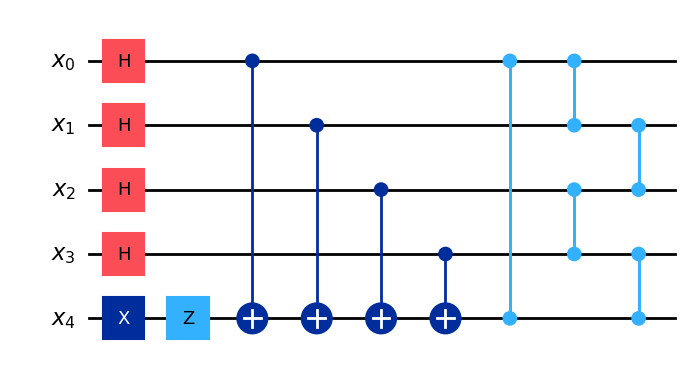

In [10]:
quantum_register = QuantumRegister(size=5, name="x")
circ = QuantumCircuit(quantum_register)

circ.x(-1)
circ.compose(encoder_circ, inplace=True)

circ.draw("mpl")

In [11]:
logical_1 = Statevector(circ)

Let's check that the coefficients are what we expect.  They should all be real:

In [12]:
for x in logical_1.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should all be $0$ or $\pm 1/4$:

In [13]:
a = np.abs(4 * logical_1.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

In [14]:
for i, coef in enumerate(4 * logical_1.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

 -1: [1 0 0 0 0]
 -1: [0 1 0 0 0]
 -1: [0 0 1 0 0]
 -1: [1 1 1 0 0]
 -1: [0 0 0 1 0]
  1: [1 1 0 1 0]
  1: [1 0 1 1 0]
 -1: [0 1 1 1 0]
 -1: [0 0 0 0 1]
 -1: [1 1 0 0 1]
  1: [1 0 1 0 1]
  1: [0 1 1 0 1]
 -1: [1 0 0 1 1]
  1: [0 1 0 1 1]
 -1: [0 0 1 1 1]
  1: [1 1 1 1 1]


Let's test against the $g_i$'s:

In [15]:
quantum_register_1 = QuantumRegister(size=5, name="x")
set_1 = QuantumCircuit(quantum_register_1)
set_1.x(-1)

for i, gi in enumerate(g):
    output_0 = Statevector(encoder_circ.compose(gi))
    output_1 = Statevector(set_1.compose(encoder_circ.compose(gi)))

    cond = np.array_equal(output_0.data, logical_0.data) and np.array_equal(output_1, logical_1.data)

    if not cond:
        print("Failed!")
        break
else:
    print("It worked!")

It worked!


## Error Correction

[Five and Seven Qubit Codes](https://www.physics.unlv.edu/~bernard/MATH_book/Chap9/Notebook9_3.pdf)

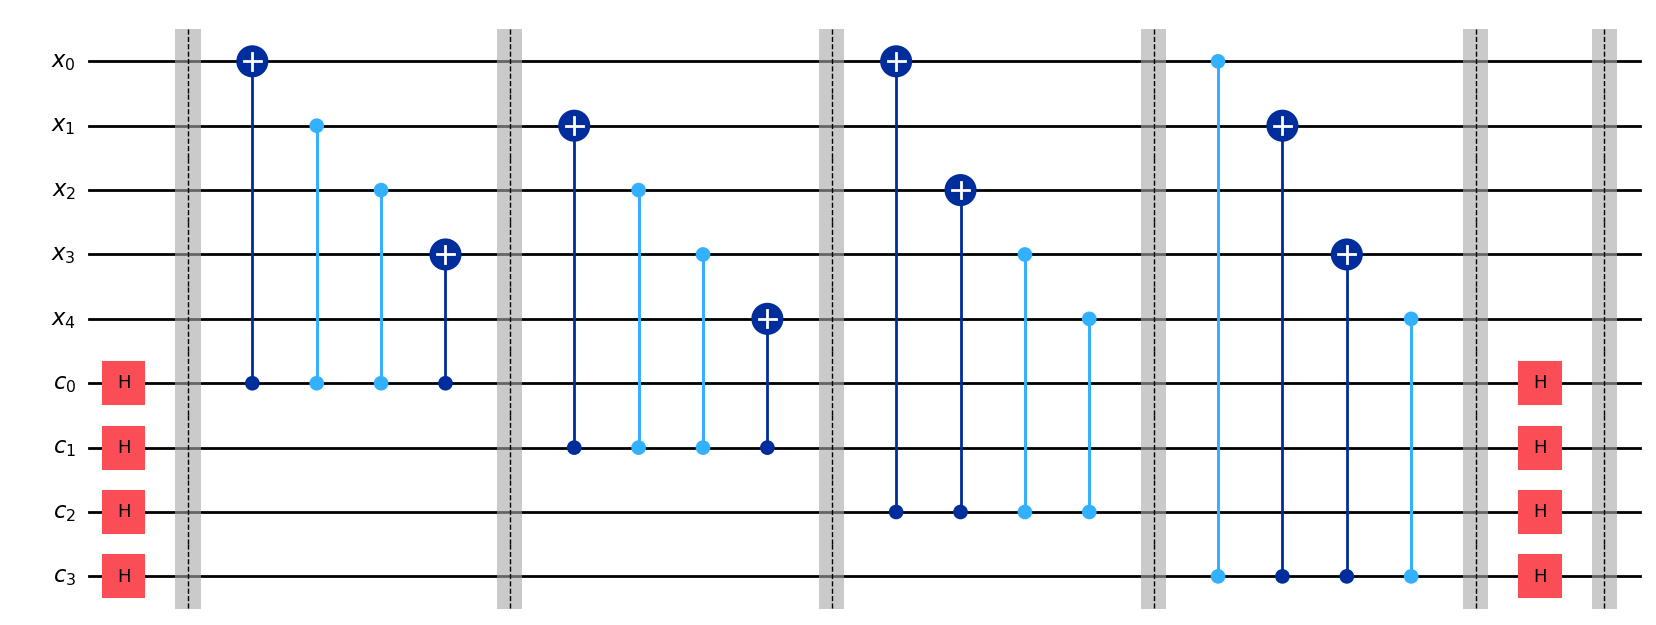

In [16]:
register_size = len(g_gates_str[0])
checks_size = len(g_gates_str)

quantum_register = QuantumRegister(size=register_size, name="x")
checks_register = AncillaRegister(size=checks_size, name="c")

code_circuit = QuantumCircuit(quantum_register, checks_register)

code_circuit.h(checks_register)
code_circuit.barrier()

for i, gates in enumerate(g_gates_str):
    for j, gate in enumerate(gates):
        if gate == "x":
            code_circuit.cx(checks_register[i], quantum_register[j])
        elif gate == "z":
            code_circuit.cz(checks_register[i], quantum_register[j])
    code_circuit.barrier()
code_circuit.h(checks_register)
code_circuit.barrier()

code_circuit.draw("mpl")

In [17]:
# OLD WAY (FROM NOTES -- NOT WORKING)

# register_size = len(g_gates_str[0])
# checks_size = len(g_gates_str)

# quantum_register = QuantumRegister(size=register_size, name="x")
# checks_register = AncillaRegister(size=checks_size, name="c")

# code_circuit = QuantumCircuit(quantum_register, checks_register)

# for i, gates in enumerate(g_gates_str):
#     for j, gate in enumerate(gates):
#         if gate == "x":
#             code_circuit.cx(quantum_register[j], checks_register[i])
#     if "z" in gates:
#         code_circuit.h(checks_register[i])
#         for j, gate in enumerate(gates):
#             if gate == "z":
#                 code_circuit.cx(checks_register[i], quantum_register[j])
#         code_circuit.h(checks_register[i])
#     code_circuit.barrier()

# code_circuit.draw("mpl")

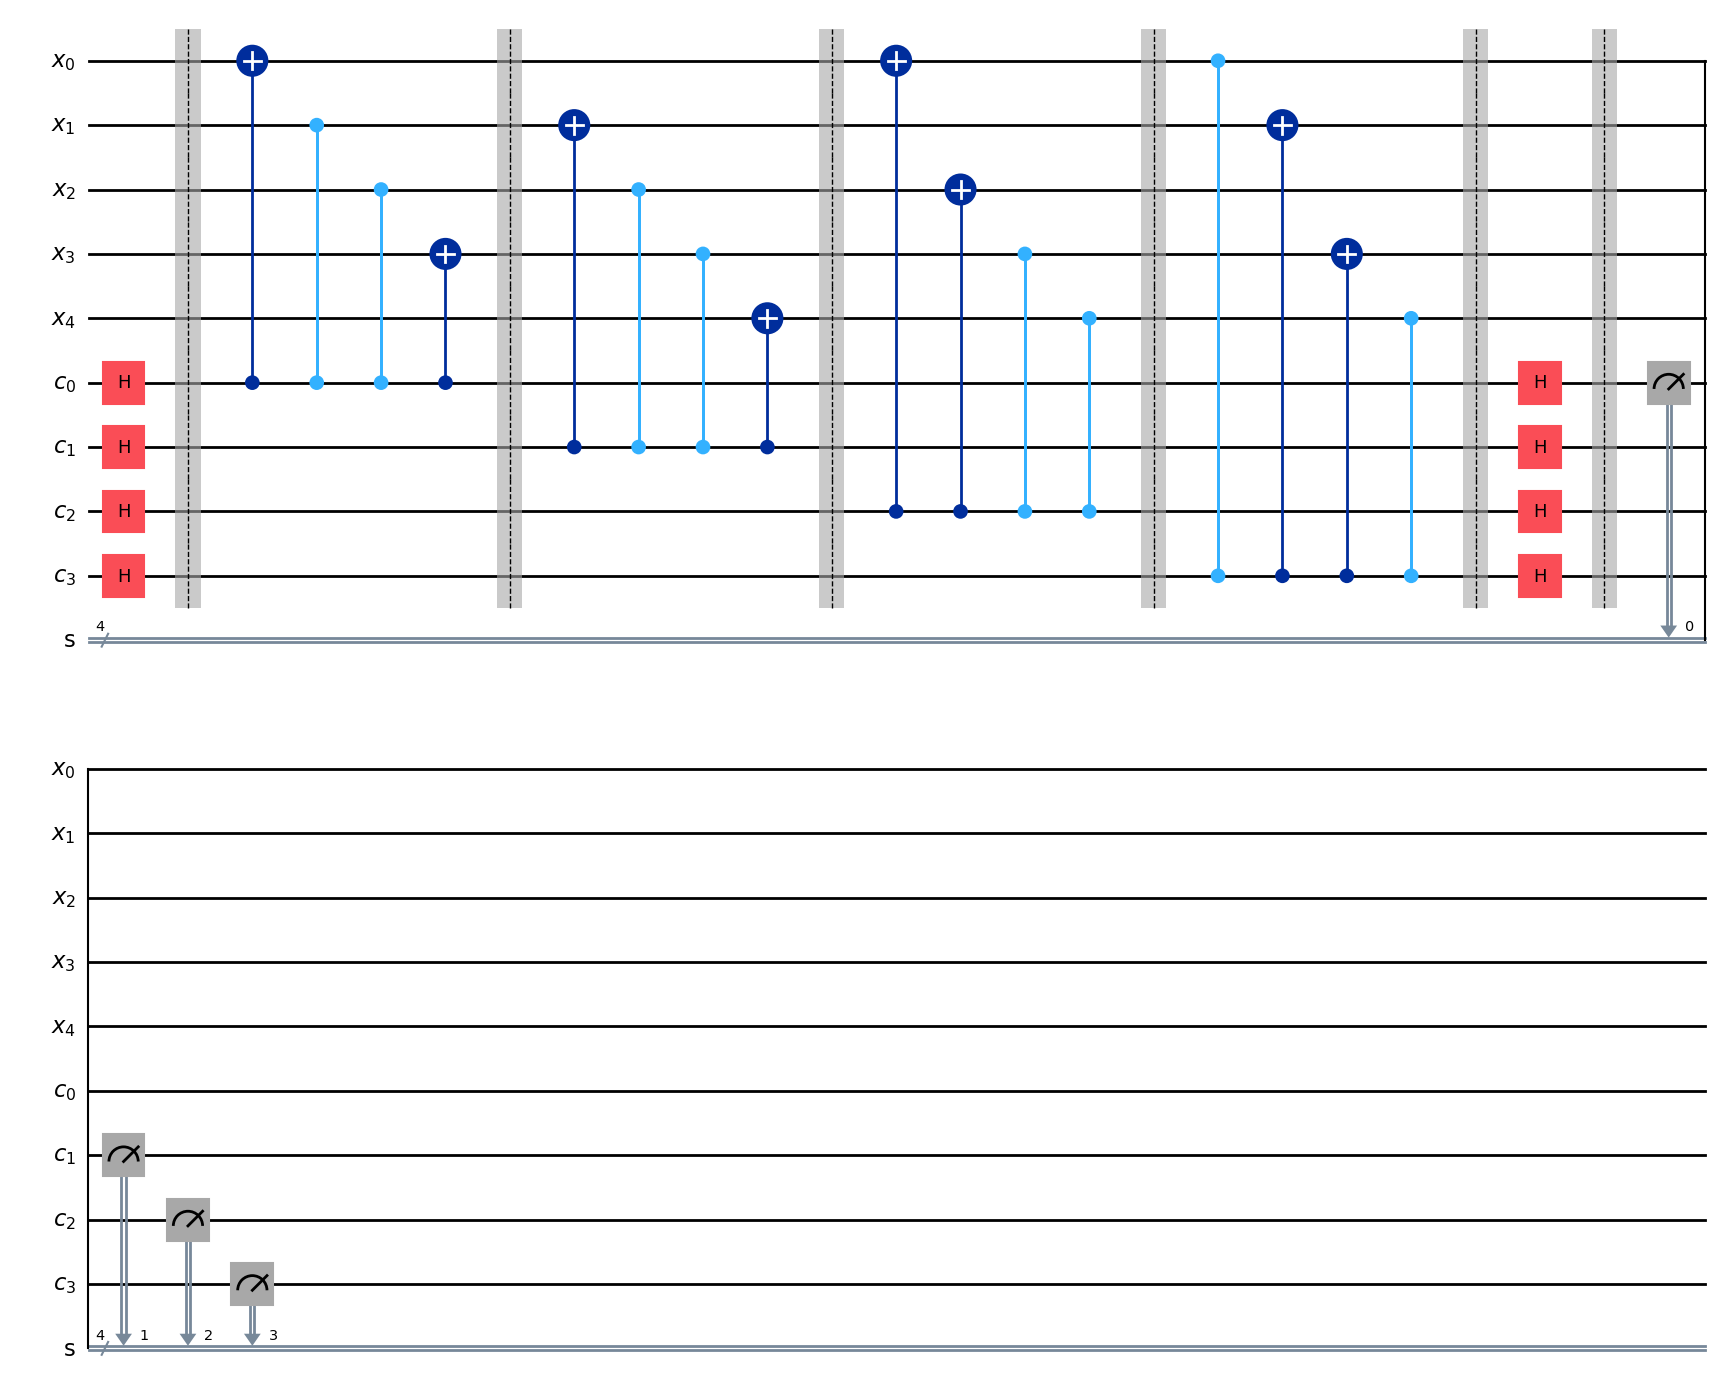

In [18]:
syndromes = ClassicalRegister(size=checks_size, name="s")

code_circuit.add_register(syndromes)

code_circuit.measure(checks_register, syndromes)

code_circuit.draw("mpl")

In [19]:
n_qubits = len(g_gates_str[0])
n_syndromes = len(g_gates_str)

decode_dict = {}

for qubit_error in ["x", "z", "y"]:  # possible errors
    for i in range(n_qubits):  # qubit for the error
        syndrome = [0] * n_syndromes
        for j, gi in enumerate(g_gates_str):  # gates
            # print(gi, qubit_error, i, j)
            if gi[i] not in [qubit_error, "i"]:
                syndrome[j] = 1
        decode_dict[(qubit_error, i)] = syndrome
        print(f"{qubit_error}_{i}: {syndrome}")

x_0: [0, 0, 0, 1]
x_1: [1, 0, 0, 0]
x_2: [1, 1, 0, 0]
x_3: [0, 1, 1, 0]
x_4: [0, 0, 1, 1]
z_0: [1, 0, 1, 0]
z_1: [0, 1, 0, 1]
z_2: [0, 0, 1, 0]
z_3: [1, 0, 0, 1]
z_4: [0, 1, 0, 0]
y_0: [1, 0, 1, 1]
y_1: [1, 1, 0, 1]
y_2: [1, 1, 1, 0]
y_3: [1, 1, 1, 1]
y_4: [0, 1, 1, 1]


In [20]:
decode_dict

{('x', 0): [0, 0, 0, 1],
 ('x', 1): [1, 0, 0, 0],
 ('x', 2): [1, 1, 0, 0],
 ('x', 3): [0, 1, 1, 0],
 ('x', 4): [0, 0, 1, 1],
 ('z', 0): [1, 0, 1, 0],
 ('z', 1): [0, 1, 0, 1],
 ('z', 2): [0, 0, 1, 0],
 ('z', 3): [1, 0, 0, 1],
 ('z', 4): [0, 1, 0, 0],
 ('y', 0): [1, 0, 1, 1],
 ('y', 1): [1, 1, 0, 1],
 ('y', 2): [1, 1, 1, 0],
 ('y', 3): [1, 1, 1, 1],
 ('y', 4): [0, 1, 1, 1]}

In [21]:
code_test = code_circuit.copy()

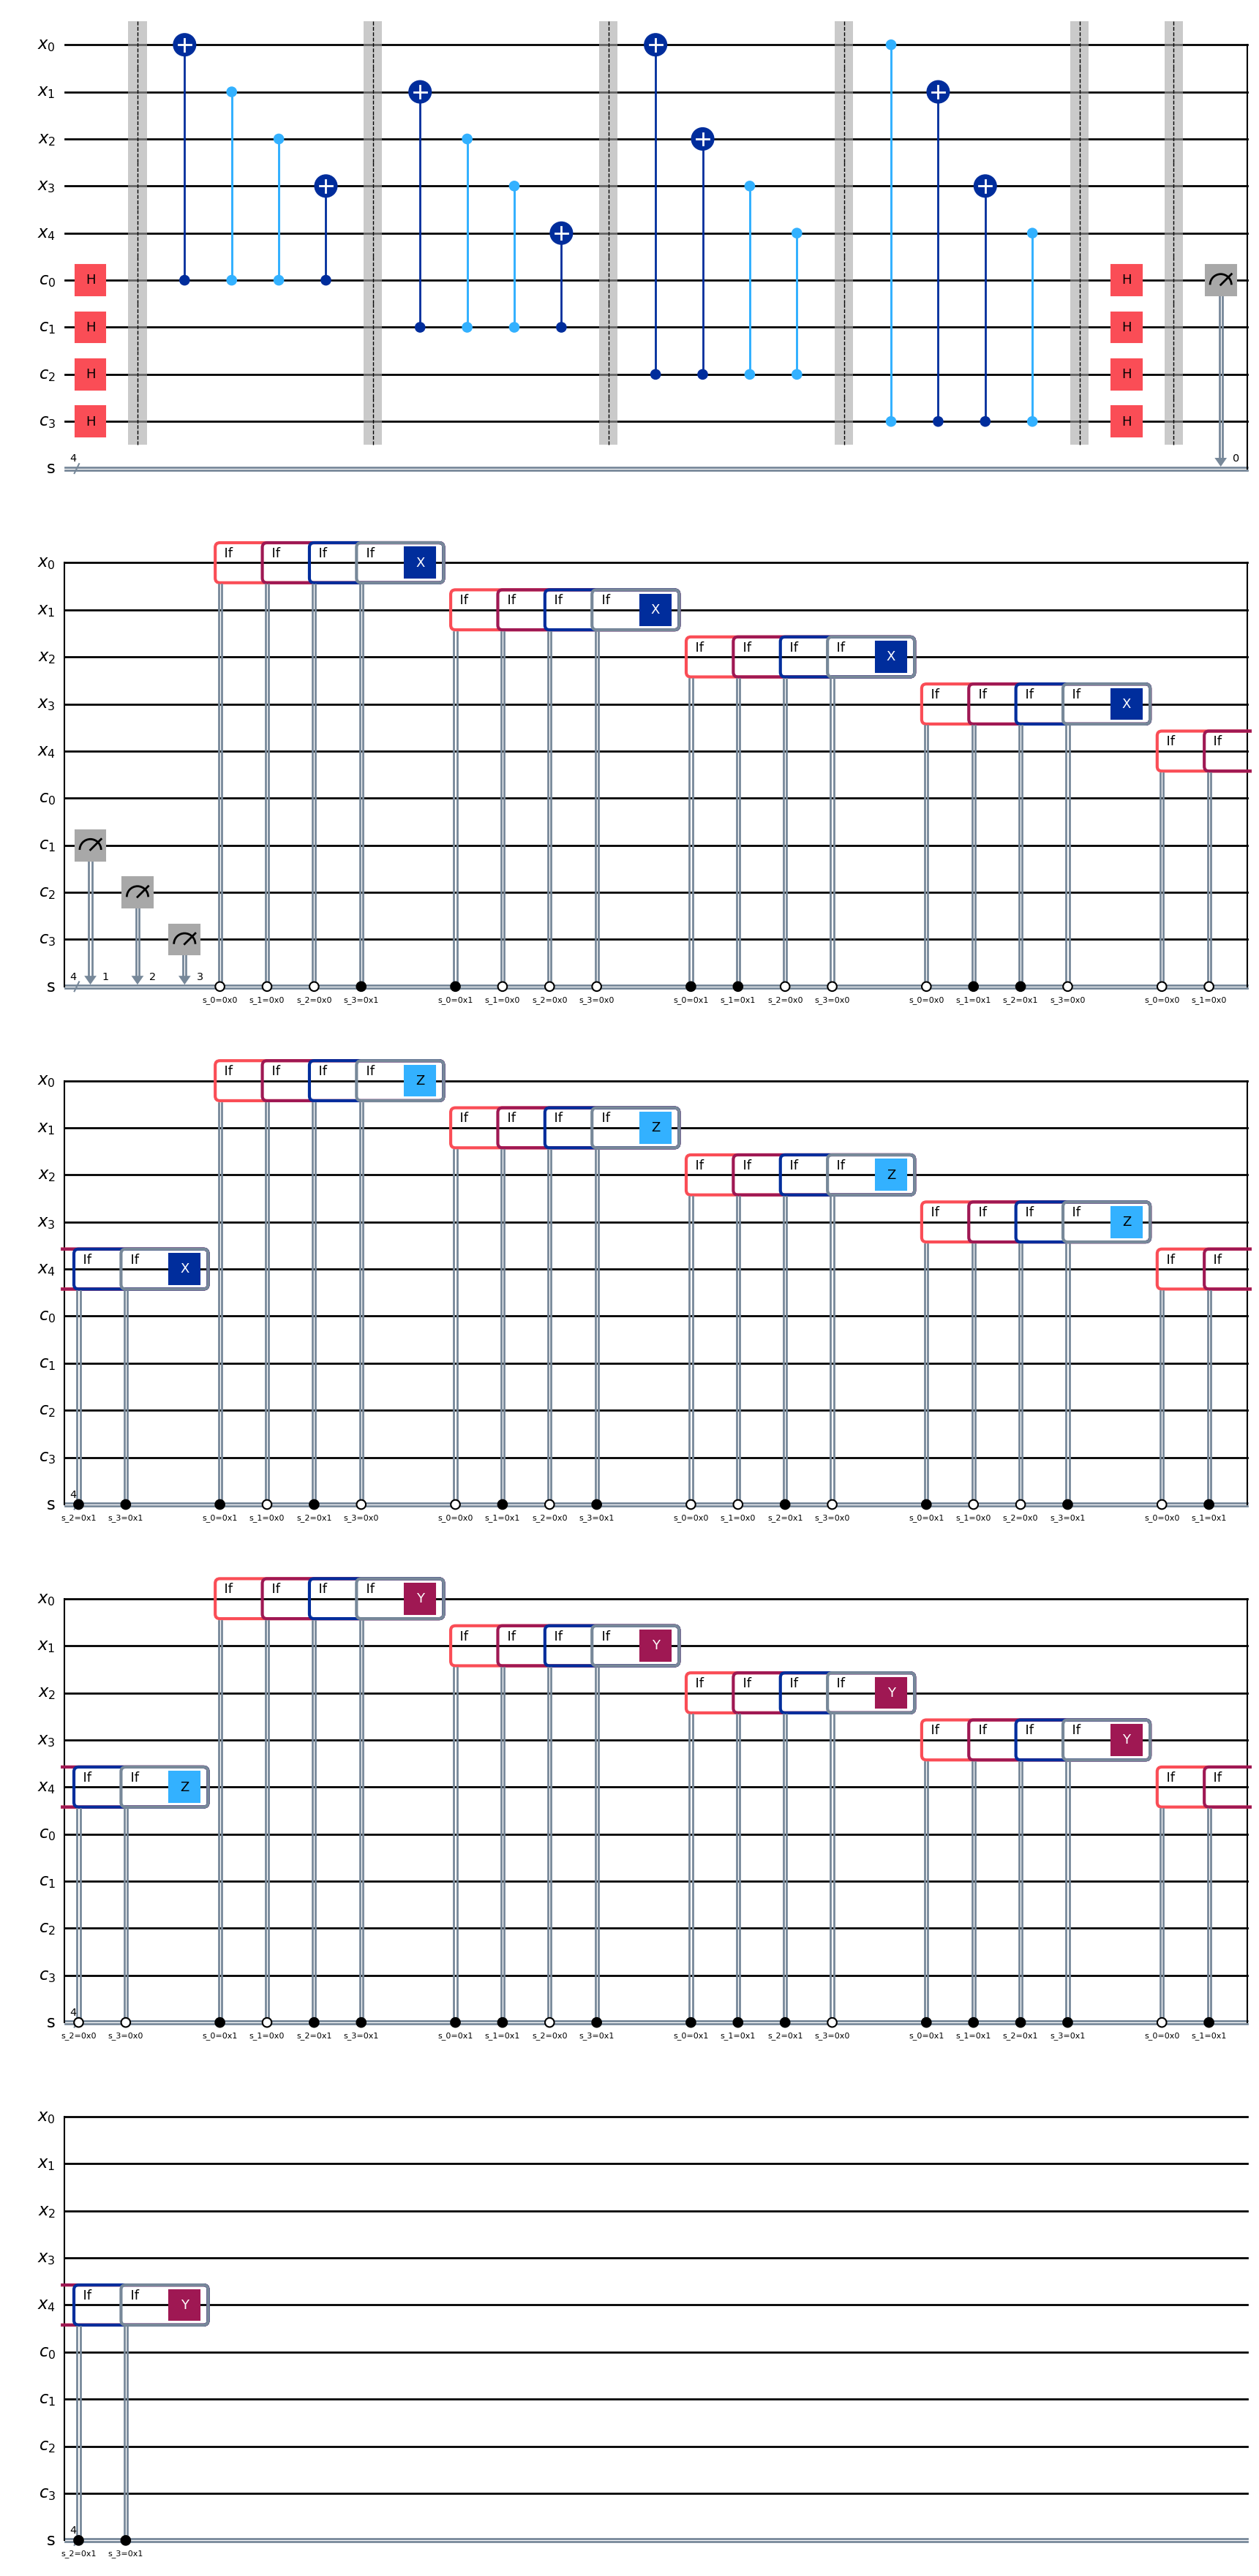

In [22]:
# for error, values in decode_dict.items():
#     with code_circuit.if_test((syndromes[0], values[0])):
#         with code_circuit.if_test((syndromes[1], values[1])):
#             with code_circuit.if_test((syndromes[2], values[2])):
#                 with code_circuit.if_test((syndromes[3], values[3])):
#                     if error[0] == "x":
#                         code_circuit.x(error[1])
#                     elif error[0] == "z":
#                         code_circuit.z(error[1])
#                     elif error[0] == "y":
#                         code_circuit.y(error[1])

def add_5_qubit_correction(circuit, qubits, syndromes):
    for error, values in decode_dict.items():
        with circuit.if_test((syndromes[0], values[0])):
            with circuit.if_test((syndromes[1], values[1])):
                with circuit.if_test((syndromes[2], values[2])):
                    with circuit.if_test((syndromes[3], values[3])):
                        if error[0] == "x":
                            circuit.x(qubits[error[1]])
                        elif error[0] == "z":
                            circuit.z(qubits[error[1]])
                        elif error[0] == "y":
                            circuit.y(qubits[error[1]])

add_5_qubit_correction(code_test, code_test.qubits[0:5], code_test.clbits)

code_test.draw("mpl")

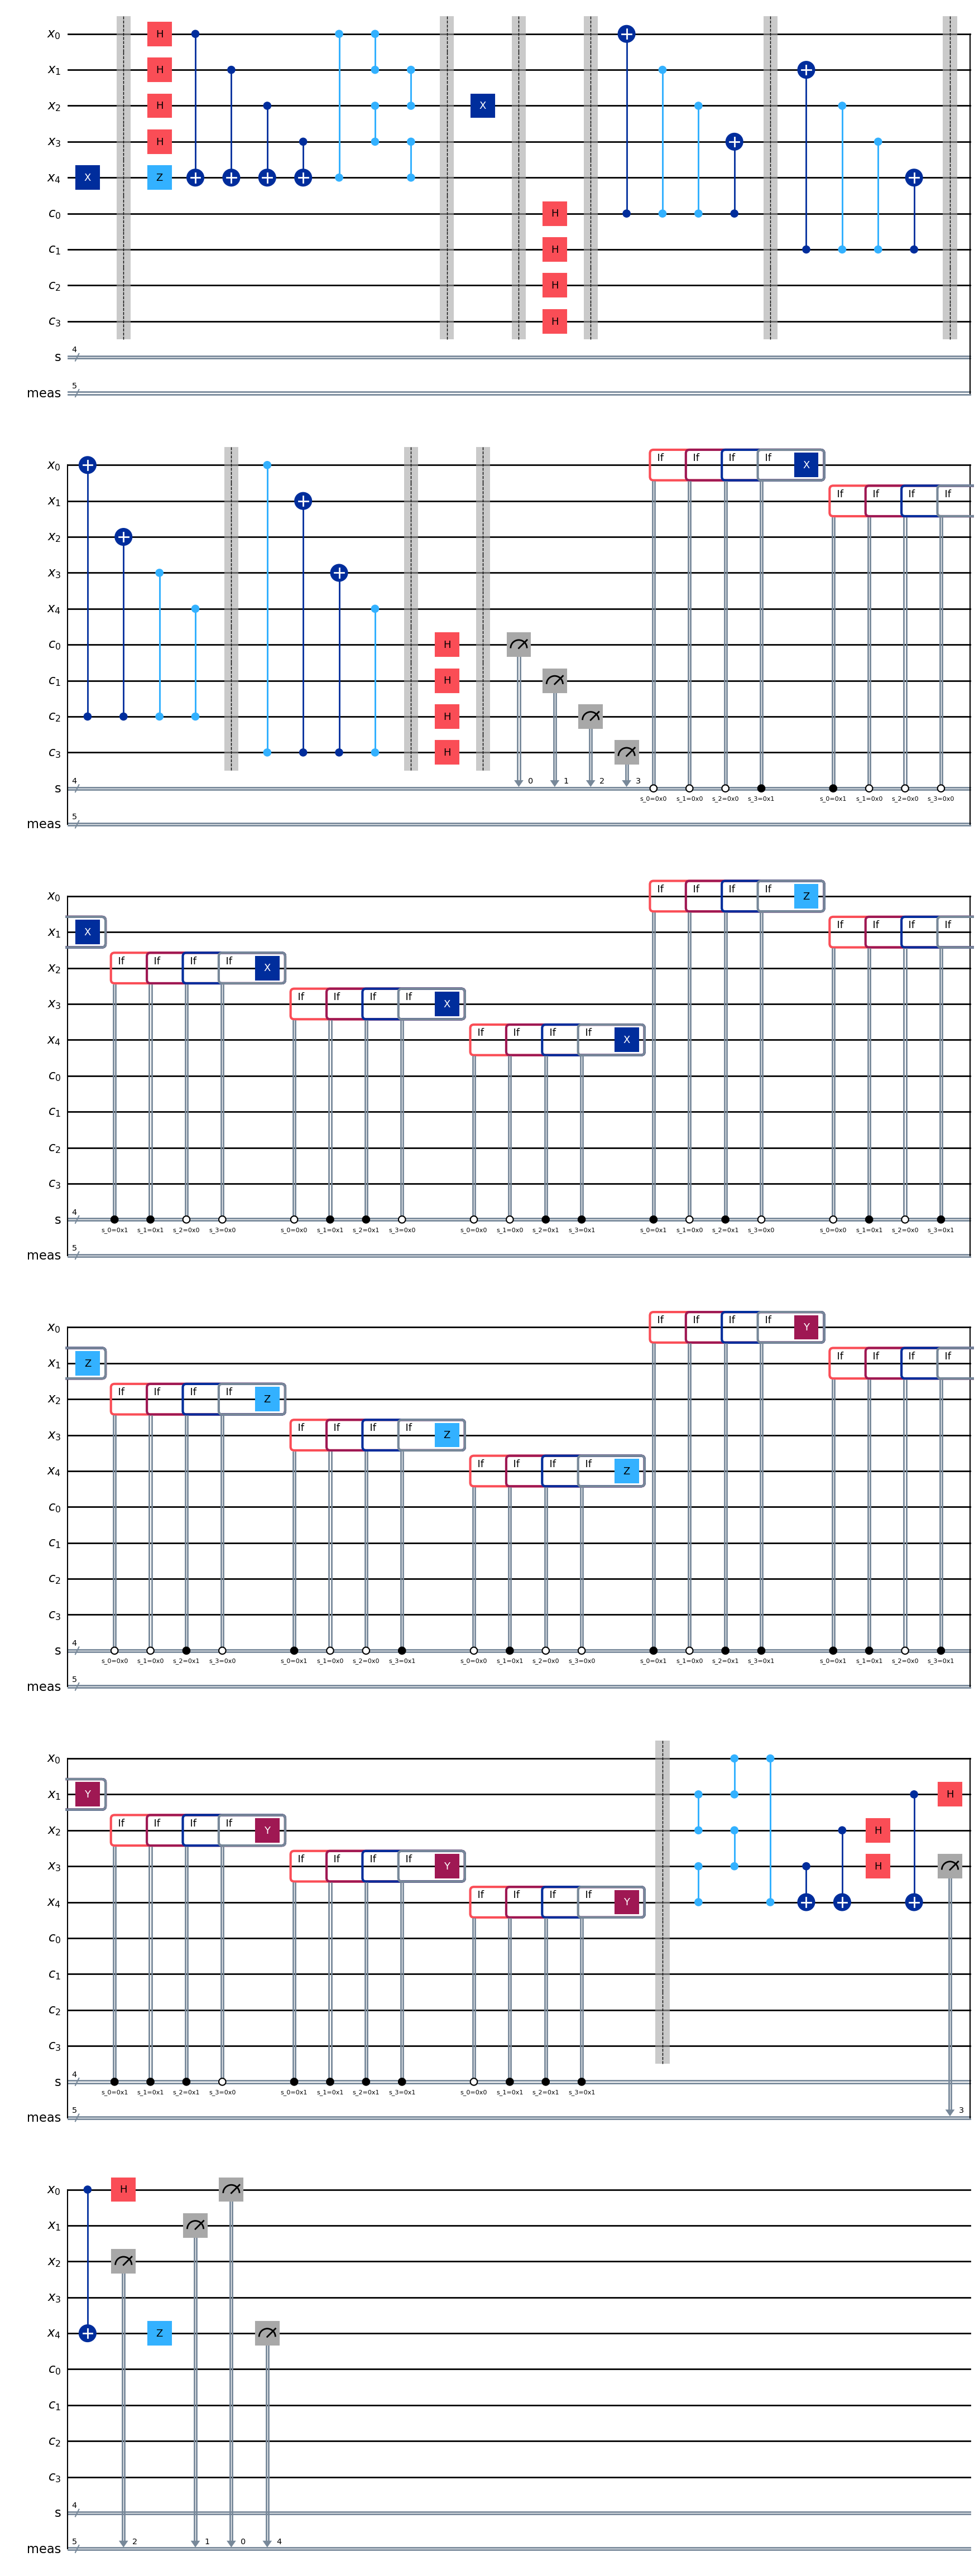

In [23]:
quantum_register = QuantumRegister(size=5, name="x")
checks_register = AncillaRegister(size=4, name="c")
syndromes = ClassicalRegister(size=4, name="s")

qubit_measurements = ClassicalRegister(size=5, name="meas")

test_circuit = QuantumCircuit(quantum_register, checks_register, syndromes)

test_circuit.x(quantum_register[-1])
test_circuit.barrier()

test_circuit.compose(encoder_circ, inplace=True)
test_circuit.barrier()

test_circuit.x(quantum_register[2])
test_circuit.barrier()

test_circuit.compose(code_test, inplace=True)
test_circuit.barrier()

test_circuit.compose(encoder_circ.inverse(), inplace=True)

test_circuit.add_register(qubit_measurements)

test_circuit.measure(quantum_register, qubit_measurements)

test_circuit.draw("mpl")

Simulation:

In [24]:
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(test_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=10)

# Get the measurement counts
counts = job.result().get_counts()

In [25]:
counts

{'10000 0011': 10}

In [26]:
counts.keys()

dict_keys(['10000 0011'])

## Two Qubit Encoding/Decoding and Test

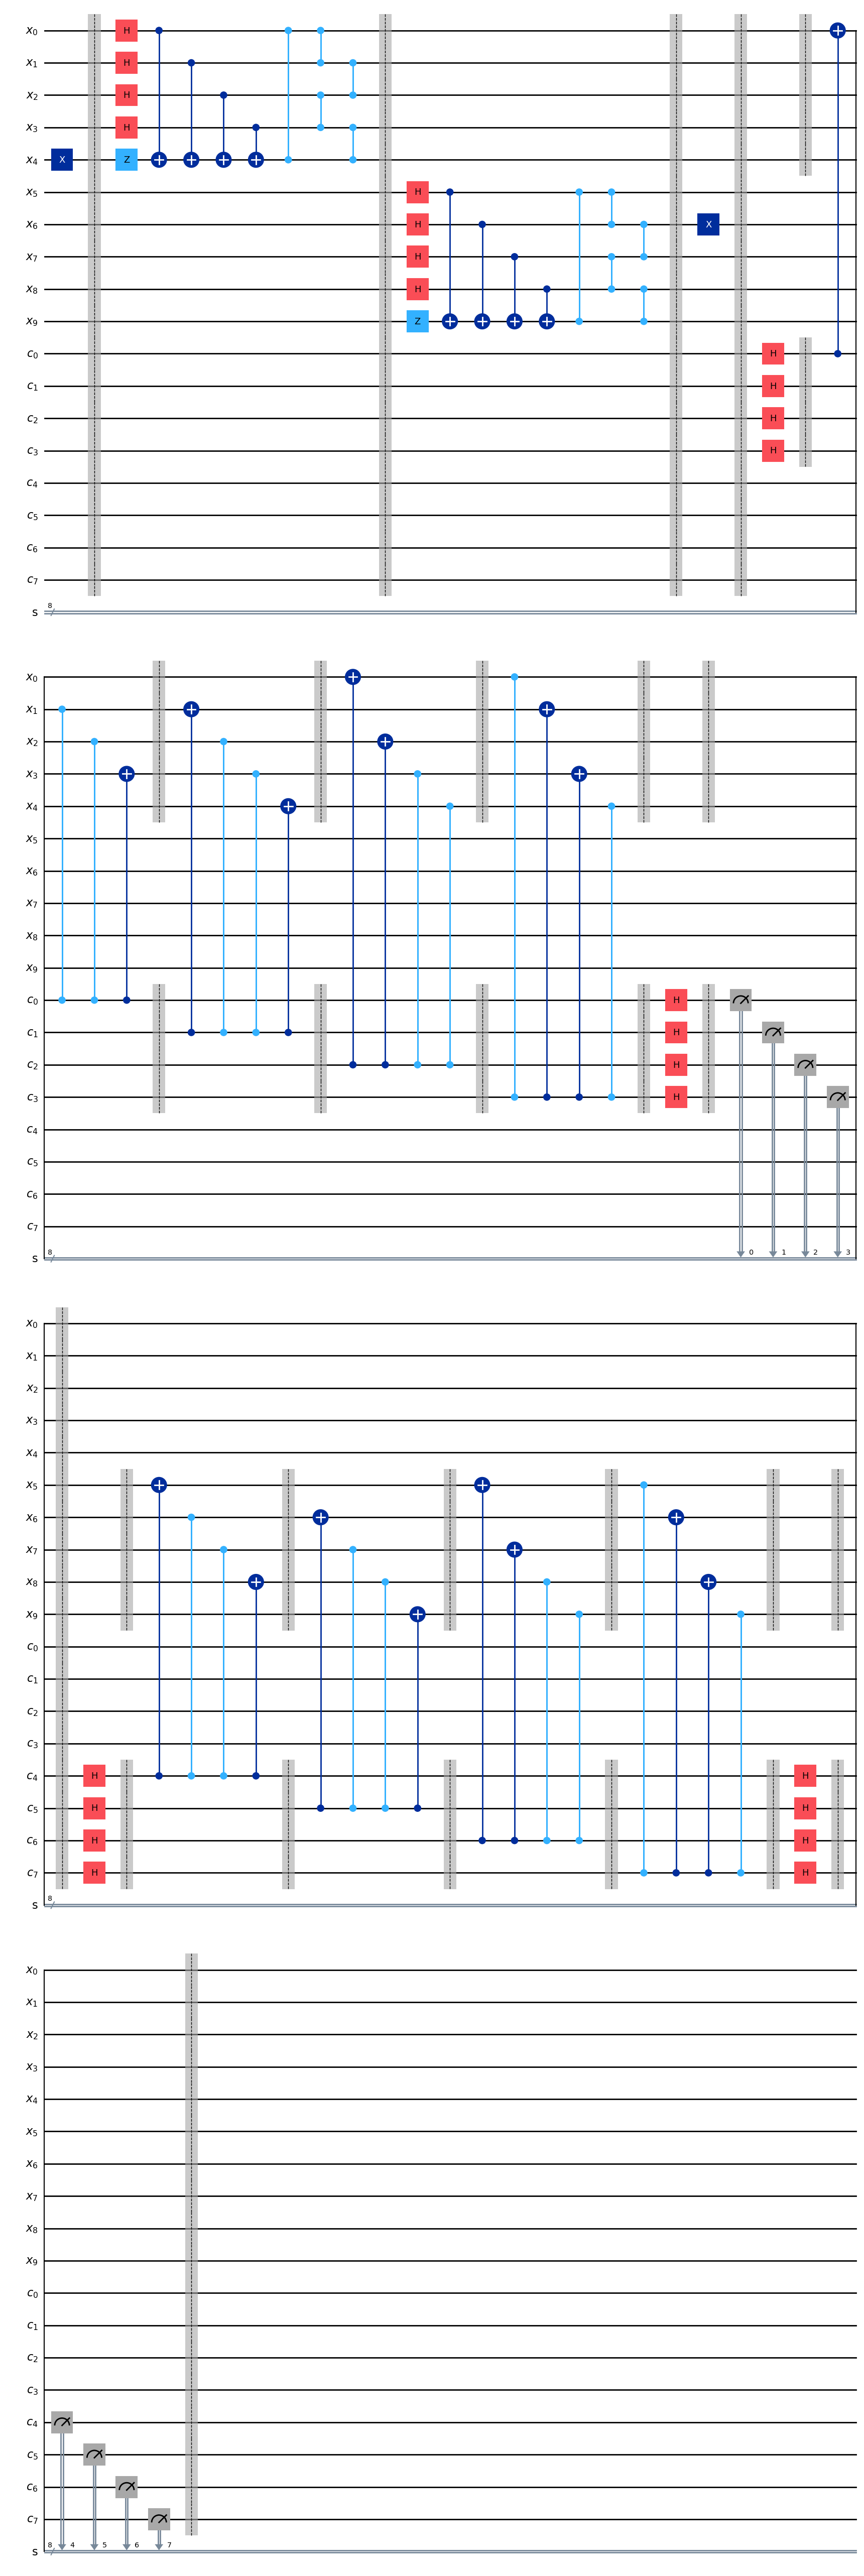

In [27]:
p = 0.15
qubits_str = "10"

#######################
n_qubits = 5
n_ancillas = 4

quantum_register = QuantumRegister(size=2 * n_qubits, name="x")
checks_register = AncillaRegister(size=2 * n_ancillas, name="c")
syndromes = ClassicalRegister(size=2 * n_ancillas, name="s")

test_circuit = QuantumCircuit(
    quantum_register,
    checks_register,
    syndromes,
)

# set initial state
for i in range(2):
    if qubits_str[i] == "1":
        test_circuit.x(quantum_register[(i + 1) * n_qubits - 1])
test_circuit.barrier()

# encoders
for i in range(2):
    test_circuit.compose(
        encoder_circ, quantum_register[i * n_qubits : (i + 1) * n_qubits], inplace=True
    )
    test_circuit.barrier()

error_occurred = ""
# random errors
for i in range(2 * n_qubits):
    rnd = np.random.random()
    if rnd < p:
        error_gate = np.random.choice(["x", "y", "z"])
        error_occurred += error_gate
        if error_gate == "x":
            test_circuit.x(quantum_register[i])
        elif error_gate == "y":
            test_circuit.y(quantum_register[i])
        else:
            test_circuit.z(quantum_register[i])
    else:
        error_occurred += "i"

test_circuit.barrier()

for i in range(2):
    test_circuit.compose(
        code_circuit,
        # qubits=[[quantum_register[i * n_qubits : (i + 1) * n_qubits]]
        #     + [checks_register[i * n_ancillas : (i + 1) * n_ancillas]]
        # ],
        qubits=
            list(range(i * n_qubits, (i + 1) * n_qubits))
            + list(
                range(
                    2 * n_qubits + i * n_ancillas, 
                    2 * n_qubits + (i + 1) * n_ancillas
                )
            ),
        clbits=syndromes[i * n_ancillas : (i + 1) * n_ancillas],
        # quantum_register[i * n_qubits : (i + 1) * n_qubits]
        # + checks_register[i * n_ancillas : (i + 1) * n_ancillas]
        # + syndromes[i * n_ancillas : (i + 1) * n_ancillas],
        inplace=True,
    )
    test_circuit.barrier()

test_circuit.draw("mpl")

In [28]:
error_occurred

'iiiiiixiii'

In [29]:
for i in range(2):
    add_5_qubit_correction(
        test_circuit, 
        quantum_register[i * n_qubits: (i + 1) * n_qubits],
        syndromes[i * n_ancillas: (i + 1) * n_ancillas],
    )
    test_circuit.barrier()

for i in range(2):
    test_circuit.compose(encoder_circ.inverse(), quantum_register[i * n_qubits: (i + 1) * n_qubits], inplace=True)
    test_circuit.barrier()

#test_circuit.draw("mpl")

In [30]:
qubit_measurements = ClassicalRegister(size=2 * n_qubits, name="meas")

test_circuit.add_register(qubit_measurements)
test_circuit.measure(quantum_register, qubit_measurements)

# test_circuit.draw("mpl")

In [31]:
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(test_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=10)

# Get the measurement counts
counts = job.result().get_counts()
counts

{'0000010000 00010000': 10}

In [32]:
results = {qubits.split()[0] for qubits in counts}
results

{'0000010000'}

In [33]:
results.pop()

'0000010000'

In [36]:
def test_5_qubit_code(qubits_str, p, shots=20):
    n_qubits = 5
    n_ancillas = 4

    # registers
    quantum_register = QuantumRegister(size=2 * n_qubits, name="x")
    checks_register = AncillaRegister(size=2 * n_ancillas, name="c")
    syndromes = ClassicalRegister(size=2 * n_ancillas, name="s")

    # circuit
    test_circuit = QuantumCircuit(
        quantum_register,
        checks_register,
        syndromes,
    )

    # set initial state
    for i in range(2):
        if qubits_str[i] == "1":
            test_circuit.x(quantum_register[(i + 1) * n_qubits - 1])

    # encoders
    for i in range(2):
        test_circuit.compose(
            encoder_circ,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )

    # random errors
    error_occurred = ""
    for i in range(2 * n_qubits):
        rnd = np.random.random()
        if rnd < p:
            error_gate = np.random.choice(["x", "y", "z"])
            error_occurred += error_gate
            if error_gate == "x":
                test_circuit.x(quantum_register[i])
            elif error_gate == "y":
                test_circuit.y(quantum_register[i])
            else:
                test_circuit.z(quantum_register[i])
        else:
            error_occurred += "i"

    # encoding + correction
    # NEEDS code_circuit TO BE CONSTRUCTED FIRST!
    for i in range(2):
        test_circuit.compose(
            code_circuit,
            # qubits=[[quantum_register[i * n_qubits : (i + 1) * n_qubits]]
            #     + [checks_register[i * n_ancillas : (i + 1) * n_ancillas]]
            # ],
            qubits=list(range(i * n_qubits, (i + 1) * n_qubits))
            + list(
                range(
                    2 * n_qubits + i * n_ancillas, 2 * n_qubits + (i + 1) * n_ancillas
                )
            ),
            clbits=syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            # quantum_register[i * n_qubits : (i + 1) * n_qubits]
            # + checks_register[i * n_ancillas : (i + 1) * n_ancillas]
            # + syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            inplace=True,
        )

    # recovery
    for i in range(2):
        add_5_qubit_correction(
            test_circuit,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            syndromes[i * n_ancillas : (i + 1) * n_ancillas],
        )

    # decoding
    for i in range(2):
        test_circuit.compose(
            encoder_circ.inverse(),
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )
        test_circuit.barrier()

    # add measurements
    qubit_measurements = ClassicalRegister(size=2 * n_qubits, name="meas")

    test_circuit.add_register(qubit_measurements)
    test_circuit.measure(quantum_register, qubit_measurements)

    # simulation
    simulator = AerSimulator()

    # Transpile the circuit for the backend
    compiled_circuit = transpile(test_circuit, simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=shots)

    # Get the measurement counts
    counts = job.result().get_counts()

    # check results
    # more than one result?
    results = {qubits.split()[0] for qubits in counts}
    if len(results) > 1:
        return False, error_occurred

    # REVERSE the result!
    result = results.pop()[::-1]

    # get the logical form of each qubit
    result_split = [result[:n_qubits], result[n_qubits : 2 * n_qubits]]

    # check
    for res, qubit in zip(result_split, list(qubits_str)):
        if res != "0" * (n_qubits - 1) + qubit:
            return False, error_occurred

    return True, error_occurred

In [37]:
test_5_qubit_code("11", 0.1)

(True, 'iiiiiiiiii')

In [38]:
"".join(np.random.choice(["0", "1"], 2))

'11'

In [39]:
%%time
max_prob = 0.3
step = 0.025

xs = np.arange(0, max_prob + step, step)
ys = np.zeros_like(xs)

number_of_tries = 100

for i, p in enumerate(xs):
    count = 0
    for _ in range(number_of_tries):
        qubits_str = "".join(np.random.choice(["0", "1"], 2))
        res, _ = test_5_qubit_code(qubits_str, p)
        if res:
            count += 1
        ys[i] = count / number_of_tries

CPU times: user 1h 4min 57s, sys: 4.58 s, total: 1h 5min 2s
Wall time: 9min 30s


In [40]:
ys

array([1.  , 1.  , 0.95, 0.91, 0.91, 0.9 , 0.77, 0.71, 0.69, 0.64, 0.63,
       0.55, 0.58])

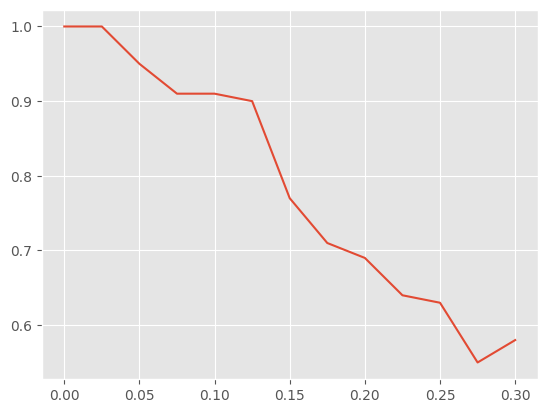

In [41]:
plt.plot(xs, ys);

In [42]:
plt.savefig("5-qb.png")

<Figure size 640x480 with 0 Axes>